# Kaggle Bike Sharing Demand
Data from: https://www.kaggle.com/c/bike-sharing-demand/overview

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

Load the training and test set into pandas Dataframes

Features:
* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals  <-- This is the target variable

In [78]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


Check for null values in the test and train set

In [79]:
train_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [80]:
test_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

There are no null values in the dataframes. We can see that the test set is missing the Casual and Registered attributes, so I'll consider removing these features from the training set.

In [81]:
train_df = train_df.drop(['casual','registered'], axis=1)

I will extract the year, month, day of the week and hour from the timestamp. The date number of the month shouldn't be critical, however the day of the week may be important. For note, day 0 = Monday

In [82]:
train_df['Year'] = pd.to_datetime(train_df['datetime']).dt.year
train_df['Month'] = pd.to_datetime(train_df['datetime']).dt.month
train_df['Day'] = pd.to_datetime(train_df['datetime']).dt.weekday
train_df['Hour'] = pd.to_datetime(train_df['datetime']).dt.hour
train_df = train_df.drop('datetime', axis=1)

test_df['Year'] = pd.to_datetime(test_df['datetime']).dt.year
test_df['Month'] = pd.to_datetime(test_df['datetime']).dt.month
test_df['Day'] = pd.to_datetime(test_df['datetime']).dt.weekday
test_df['Hour'] = pd.to_datetime(test_df['datetime']).dt.hour
test_date = test_df.pop('datetime') # will need the original timestap for submission

In [83]:
test_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Year,Month,Day,Hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,3,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,4


I will plot a correlation heatmap to visualize correlated features

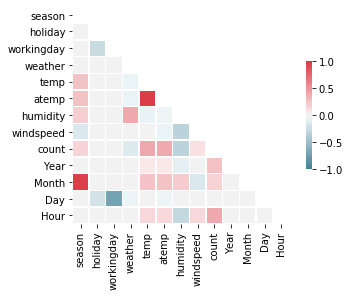

In [84]:
# compute the correlation
corr = train_df.corr()

# set a mask since the correlation matrix is symmetrical along the diagonal
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
                             
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can see that there is correlations between some features.

Positive correlation:
* It is obvious that the temperature is correlated to the apparent temperature
* The months are inherently correlated to the seasons
* for counts, there is some positive correlation to the season, temperature

Negative correlation:
* The counts are lower at higher humidity

I'll look at the median count of bike shares during the week for each season. We can see that it is peaked on Fridays and is at a minimum on Sundays.

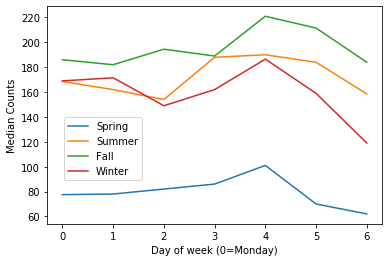

In [85]:
ax = train_df[['Day','season','count']].groupby(by=['Day','season']).median().unstack().plot()
ax.set_ylabel('Median Counts')
ax.set_xlabel('Day of week (0=Monday)')
ax.legend(["Spring", "Summer",'Fall','Winter'],loc=(0.05,0.2));

A plot of the bike share counts over the course of the day shows the clear difference in ridership for the weekday and the weekend. On the weekday, there is a high-demand right before and after work (9am-5pm) which indicates these are mostly work commuters.

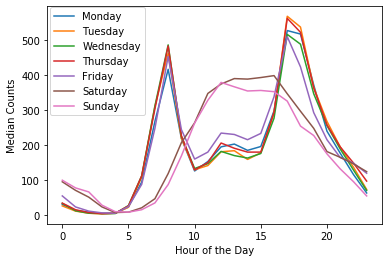

In [86]:
ax = train_df[['Hour','Day','count']].groupby(by=['Hour','Day']).median().unstack().plot()
ax.set_ylabel('Median Counts')
ax.set_xlabel('Hour of the Day')
ax.legend(["Monday", "Tuesday",'Wednesday','Thursday','Friday','Saturday','Sunday'],loc=(0.01,0.5));

I can simplify this further by plotting weekdays and weekends

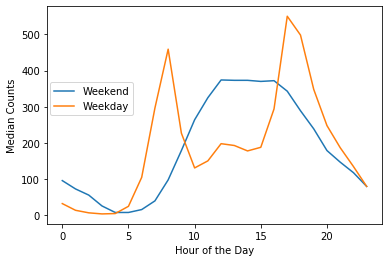

In [88]:
ax = train_df[['Hour','workingday','count']].groupby(by=['Hour','workingday']).median().unstack().plot()
ax.set_ylabel('Median Counts')
ax.set_xlabel('Hour of the Day')
ax.legend(["Weekend", "Weekday"],loc=(0.01,0.5));

Most riders do bike sharing in warmer weathers as expected.

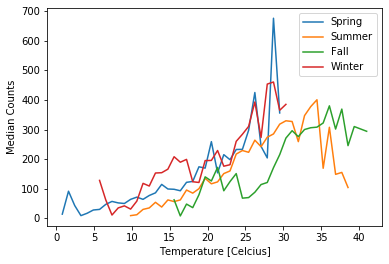

In [14]:
ax = train_df[['temp','season','count']].groupby(by=['temp','season']).median().unstack().plot()
ax.set_ylabel('Median Counts')
ax.set_xlabel('Temperature [Celcius]')
ax.legend(["Spring", "Summer",'Fall','Winter'],loc='best');

They are less likely to bike share at high humidity levels.

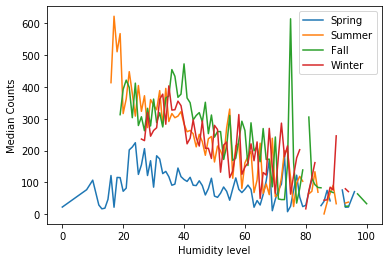

In [15]:
ax = train_df[['humidity','season','count']].groupby(by=['humidity','season']).median().unstack().plot()
ax.set_ylabel('Median Counts')
ax.set_xlabel('Humidity level')
ax.legend(["Spring", "Summer",'Fall','Winter'],loc='best');

The summer months have the most bike share ridership, whereas January has the lowest.

Text(0.5, 0, 'Month')

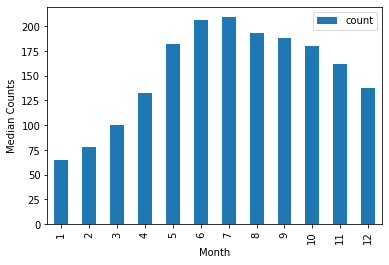

In [16]:
ax = train_df[['Month','count']].groupby(by='Month').median().plot.bar()
ax.set_ylabel('Median Counts')
ax.set_xlabel('Month')

We can visualize the distribution for the continuous variables and colour code the data by seasonality. There seems to be outliers for the windspeed where they are recorded as zeros. This also occurs less frequently for humidity. For now I will continue the analysis as it is.

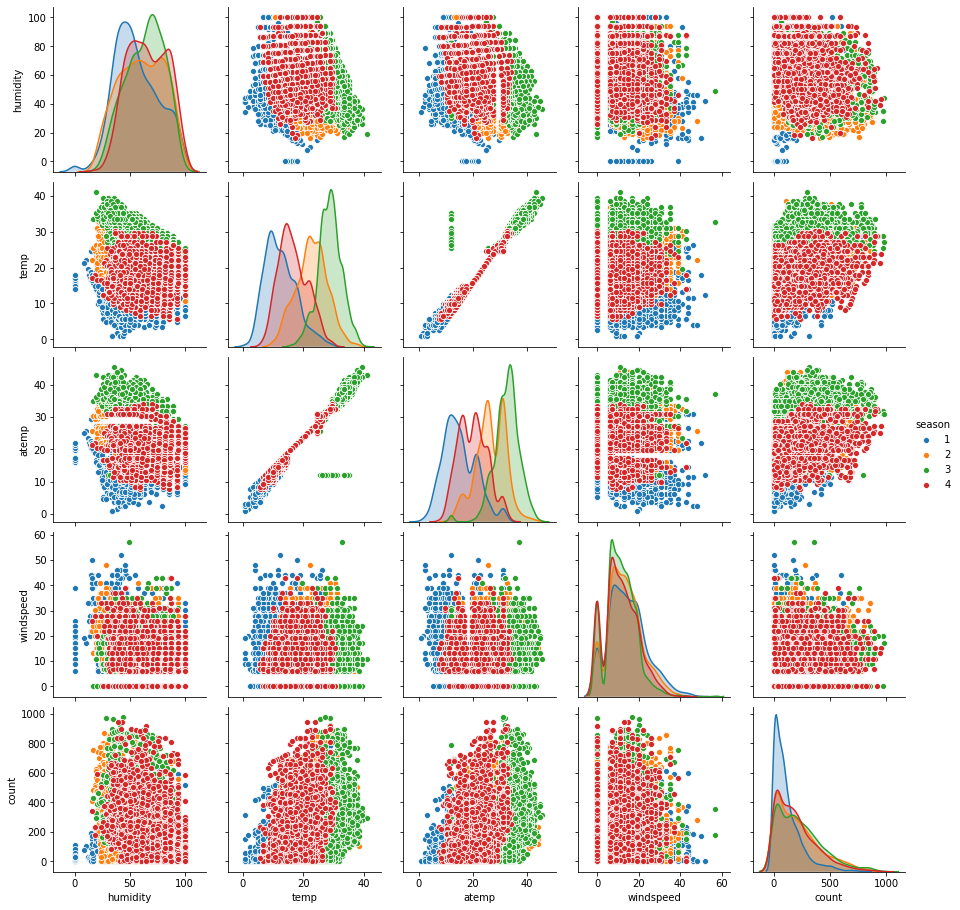

In [17]:
sns.pairplot(train_df[['season','humidity','temp','atemp','windspeed','count']],hue="season")

Take the Counts target variable out of the training dataframe

In [18]:
y = train_df.pop('count')

I'll split the training dataframe into a training subset and a validation subset to validate the machine learning model

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df, y, test_size=0.33, random_state=42)

In [89]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Year,Month,Day,Hour
1101,1,0,1,3,17.22,21.210,0,15.0013,2011,3,3,12
4194,4,0,1,1,21.32,25.000,59,7.0015,2011,10,3,19
10389,4,0,0,1,11.48,13.635,81,12.9980,2012,11,6,7
6969,2,0,0,1,25.42,30.305,22,19.9995,2012,4,6,17
313,1,0,1,1,9.02,9.850,37,26.0027,2011,1,4,13


Let's look at the distribution of the Counts target feature. We can see that it resembles a $e^{-x}$ trend. Machine learning models typically depend on the target feature distribution to have a Normal distribution.

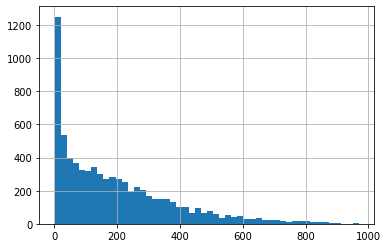

In [55]:
y_train.hist(bins=50)

I can try to transform the distribution by taking the natural logarithm. The machine learning model output will be converted back by taking the exponential. It's not exactly Gaussian, but it will perform better in the model.

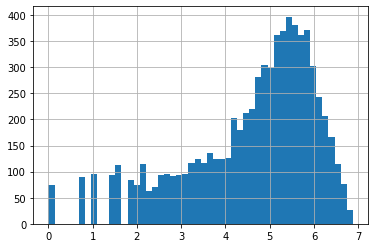

In [90]:
(np.log(y_train)).hist(bins=50)

# Machine Learning
Create a pipeline and run the model on the training set. Predict the values on the validation set. The competition suggests to use a Random Forest model.

In [42]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = ['temp','atemp','humidity','windspeed']
categorical_features = ['season','holiday','workingday','weather','Year','Month','Day','Hour']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe = Pipeline(steps=[('preprocessor', preprocessor),
               ('classifier', RandomForestRegressor(n_estimators=200, n_jobs=3))])

y_train_log = np.log(y_train)
pipe.fit(X_train, y_train_log)
y_valid_predict = np.exp(pipe.predict(X_valid))

Evaluate the model by looking at root mean squared logarithmic error (RMSLE)

In [68]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(np.round(y_valid_predict),y_valid))

0.3364791310340211

This is the distribution of the residuals

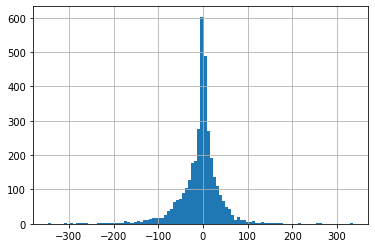

In [53]:
(y_valid_predict-y_valid).hist(bins=100)

Now predict the values for the test set

In [59]:
y_test_predict = np.exp(pipe.predict(test_df))

In [73]:
submission_df = pd.concat([test_date,pd.Series(np.round(y_test_predict),name='count')],axis=1)
submission_df

,datetime,count
0,2011-01-20 00:00:00,12.0
1,2011-01-20 01:00:00,5.0
2,2011-01-20 02:00:00,2.0
3,2011-01-20 03:00:00,3.0
4,2011-01-20 04:00:00,2.0
...,...,...
6488,2012-12-31 19:00:00,176.0
6489,2012-12-31 20:00:00,137.0
6490,2012-12-31 21:00:00,127.0
6491,2012-12-31 22:00:00,100.0


In [74]:
submission_df.to_csv('Submissions_Bike_Sharing_Demand.csv',index=False)